# Segmentacja obrazów

## Cel ćwiczenia
- zapoznanie z metodami segmentacji obrazów:
    - segmentacją przez rozrost obszaru (*region growing*)
    - i w ramach zadania domowego segmentacją przez podział i łączenie (*split and merge*)

## Wstęp

W ramach dotychczas wykonanych ćwiczeń poznaliśmy segmentację z wykorzystaniem binaryzacji (progowania) - tj. na podstawie jasności (koloru) poszczególnych pikseli.
Wykonaliśmy dwa warianty metody: globalny i lokalny oraz przetestowaliśmy różne podejścia do automatycznego wyznaczania progu bianryzacji (iteracyjne oraz Otsu).
Ponadto poznaliśmy możliwość segmentacji na podstawie krawędzi z wykorzystaniem transformaty Hougha.

## Podstawy

Niech $R$ oznacza obszar równy całemu analizowanemu obrazowi.
Segmentację możemy uznać za proces podziału $R$ na $n$ podobszarów $R_1,R_2,...,R_n$ takich że:
1. $\cup_{i=1}^n R_i = R$
2. $R_i$ - składa się z połączonych ze sobą pikseli,
3. $R_i \cap R_j = \varnothing $ dla wszystkich $i$ i $j$,$ i \neq j$,
4. $Q(R_i) = TRUE$ dla $i = 1,2,...n$
5. $ Q(R_i \cup R_j) = FALSE$ dla każdych sąsiednich $R_i$ i $R_j$.

gdzie: symbole $\cup$ i $\cap$ oznaczają odpowiednio sumę i iloczyn zbiorów, a $Q$ jest pewnym predykatem.

Punkt *1* oznacza, że segmentacja musi być kompletna tj. każdy piksel powinien zostać przyporządkowany do jakiegoś zbioru.

Punkt *2* oznacza, że piksele w ramach jednego podobszaru muszą być ze sobą połączone (na zasadzie sąsiedztwa 4 lub 8 punktowego).

Punkt *3* oznacza, że dowolne różne podobszary muszą być rozłączne.

Punkt *4* oznacza, że wszystkie piksele będące w ramach jednego podobszaru muszą spełniać pewną własność. Przykładowo może to być ten sam lub podobny odcień szarości.

Punkt *5* oznacza, że dwa sąsiednie podobszary muszą być różne w sensie predykatu Q (inaczej powinny zostać uznane za ten sam podobszar).

## Segmentacja przez rozrost obszaru

Pomysł jest następujący.
Wybieramy (jak ? - o tym później) piksele startowe (ang. *seed*) i od nich zaczynamy segmentację.
Odbywa się ona na zasadzie sprawdzania czy sąsiednie piksele (sąsiedztwo 4 lub 8 punktowe) są podobne do centralnego pod względem jakieś cechy (predykatu $Q$).
Jeśli tak to oznaczane są jako należące do tej samej klasy co piksel centralny.
Ponadto stają się one kolejnymi punktami startowymi metody.
Zatem procedura ma charakter rekurencyjny.

Wybór punktów startowych może być podyktowany charakterem problemu (przykładowo wiemy gdzie na pewno zaczynają się obiekty).
W ogólnym przypadku trzeba założyć, że pikselem startowym może być każdy piksel, co oczywiście wpływa na złożoność metody.

Kolejnym problemem jest wybór kryterium stopu tj. kiedy nasza procedura rekurencyjna ma się zakończyć.
Dla danego podobszaru będzie to moment, kiedy nie istnieją już piksele, które można do  niego dołączyć.

Warto w tym miejscu zwrócić uwagę, że stosowanie ''sztywnego'' warunku - np. różnica jasności pomiędzy pikselem centralnym, a analizowanym jest mniejsza niż 5 - może często dać niepożądane wyniki, gdyż nie uwzględnia pewnych lokalnych właściwości.
Przykładowo, może się okazać, że jeśli na obrazie występuje niewielki gradient to za należące do tego samego obszaru uznane zostaną piksele o zupełnie różnych jasnościach.
Możliwa jest też sytuacja odwrotna.
Duże zróżnicowanie wartości na obrazie spowoduje zbyt duże ''poszarpanie'' wykrytych obszarów.

Jednym z możliwych rozwiązań jest uzależnienie kryterium podobieństwa (predykatu $Q$) od własności obrazu np. średniej jasności w obrębie danego obszaru.
Można również dodać inne kryteria np. kształt podobszaru itp.

Uwaga. Pojęcie segmentacja przez rozrost to pewna **koncepcja** podejścia do segmentacji, a nie konkretna metoda.
Na etapie projektowania algorytmu należy skupić się na konstrukcji kryterium podobieństwa (tj. co i jak ma być ze sobą porównywane) oraz ewentualnym uzupełnianiu metody o dodatkowe kryteria.



In [1]:
import os
import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

if not os.path.exists("knee.png") :
    !wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/12_Segmentation/knee.png --no-check-certificate


knee = cv2.imread('knee.png', cv2.IMREAD_GRAYSCALE)

In [2]:
def img_show(image):
    plt.figure(figsize=(7, 7))
    plt.imshow(image, cmap="gray")
    plt.xticks([]), plt.yticks([])
    plt.show()


def img_gin(image):
    plt.figure(figsize=(7, 7))
    plt.imshow(image, cmap="gray")
    plt.ginput()

In [3]:
# matplotlib.use('TkAgg')
# img_gin(knee)

## Zadanie: zaprojektować system segmentacji wybranej struktury na obrazie MRI (np. stawu kolanowego).
Punkt startowy wyznaczany będzie ''ręcznie'' (poprzez kliknięcie na obrazie).

1. Wczytaj obraz *knee.png* (w skali szarości) - MRI stawu kolanowego. Wyświetl go. Załóżmy, że chcemy dokonać segmentacji górnej kości. Przyjęliśmy, że punkt startowy metody wyznaczany będzie w sposób ręczny. Do pobrania położenia kursora myszy na ekranie służy funkcja `plt.ginput`. Uwaga. Jeśli obrazki są ''osadzone'' w notatniku, funkcja nie działa - proszę zwrócić uwagę na kod `matplotlib.use('TkAgg')`, który powoduje, że obrazki wyświetlane są ''samodzielnie''.

  Uwaga 1. Pobrane współrzędne należy zaokrąglić (*floor* lub *round*).

  Uwaga 2. Dla potrzeb testów dobrze jest wpisać punkt startowy na ''sztywno''. Pozwoli to uniknąć dość irytującego klikania przy każdym uruchomieniu skryptu.


2. Metodę zaimplementujemy z wykorzystaniem stosu.
   Uwaga. Podany poniżej opis jest tylko jedną z możliwych realizacji (niekoniecznie najlepszą).
   Na początek tworzymy dwie macierze o rozmiarach takich jak analizowany obraz.
   W jednej będziemy zapisywać odwiedzone lokalizacje (`visited` - typ *boolean*), a w drugiej rezultaty segmentacji (`segmented`).
   Obie macierze tworzymy wypełnione zerami (funkcja `np.zeros`).
   Tworzymy też stos - w Python to po prostu ''pusta lista''.

3. W pierwszym kroku metody na stos (`stack.append`) odkładamy współrzędne wybranego przez użytkowania piksela.
   Oznaczamy go również jako odwiedzony (macierz *visited*) i zaliczony do obiektu (macierz *segmented*).

4. Pozostałe działanie odbywać się będzie w pętli `while`, której warunkiem stopu jest obecność elementów na stosie (`len(stack)>0`).
 W iteracji należy pobrać współrzędne piksela ze stosu.
  Następnie sprawdzamy, czy dla tego piksela można określić kontekst o rozmiarze $ 3 \times 3$ tj. czy ma wszystkich sąsiadów.
  Uwaga. Przyjmujemy tutaj uproszczenie - nie segmentujemy brzegu obrazka (ramki o szerokości 1 piksela).

5. W kolejnym kroku rozpisujemy pętlę po otoczeniu $3 \times 3$ (x2 `for`).
   Wewnątrz obliczamy odległość pomiędzy pikselem centralnym, a każdym z kontekstu.
   Przyjmijmy, że będzie to moduł z różnicy jasności.
   Jeśli wartość modułu będzie mniejsza od zdefiniowanego progu (proszę przyjąć jako początkową wartość 4) oraz rozpatrywany piksel nie był wcześniej odwiedzany to oznaczamy go jako należący do obiektu oraz jego współrzędne ''odkładamy'' na stosie.
   Uwaga. Pierwsza część warunku logicznego to nasz predykat Q.
   Za piksele podobne uznajemy takie, których różnica w jasności jest mniejsza niż zadany próg.
   Niezależnie od wyniku testu oznaczamy piksel jako odwiedzony (żeby wielokrotnie nie analizować tych samych lokalizacji).

6. Poza pętlą `while` proszę wyświetlić rezultat segmentacji.
   Czy wyniki są poprawne ?
   Proszę poeksperymentować z wartością progu.

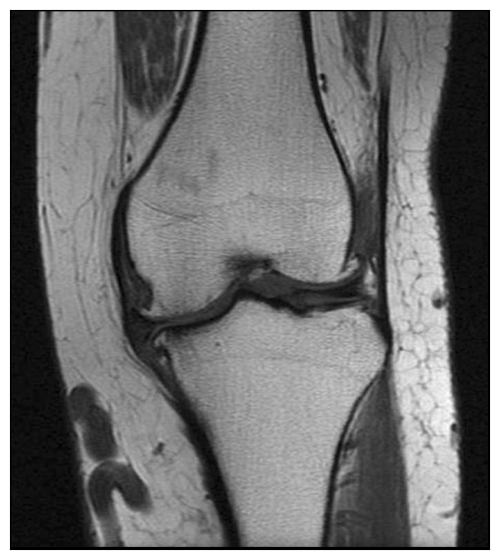

In [4]:
img_show(knee)

In [5]:
def seg(image: np.ndarray, threshold: float, x: int, y: int):
    img_x, img_y = image.shape
    image = image.astype('float32')
    visited = np.zeros((img_x, img_y))
    segmented = np.zeros((img_x, img_y))
    stack = []
    stack.append((x, y))
    visited[x, y] = True
    segmented[x, y] = image[x, y]
        
    while len(stack):
        p = stack.pop()
        if p[0] < img_x - 1 and p[1] < img_y - 1 and p[0] > 0 and p[1] > 0:
            surr = image[p[0] - 1:p[0] + 2, p[1] - 1:p[1] + 2]
            for i in range(3):
                for j in range(3):
                    diff = np.abs(surr[1, 1] - surr[i, j])
                    pp = [p[0] - 1 + i, p[1] - 1 + j]
                    if diff < threshold and visited[pp[0], pp[1]] == 0:
                        stack.append(pp)
                        segmented[pp[0], pp[1]] = image[pp[0], pp[1]]

                    visited[pp[0], pp[1]] = 1
    return segmented

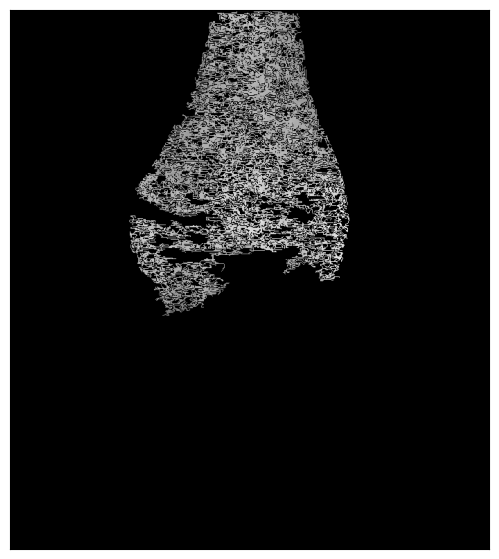

In [6]:
knee_seg = seg(knee, 4, 350, 183)
img_show(knee_seg)

1. Powyższy przykład ukazuje wspomniany wcześniej problem z ''globalnym'' podejściem do predykatu Q.
  Jeśli próg będzie mały, to wyznaczymy jedynie niewielki fragment kości.
  Natomiast zwiększenie progu skutkuje segmentacją nadmiarową.
  Mówiąc kolokwialnie, na obrazie znajdzie się ''ścieżka'' po której możliwe jest przejście od obszaru jasnego do ciemnego nie ''łamiąc'' progu odległości pomiędzy sąsiednimi pikselami.

2. Aby zaradzić powyższemu problemowi, można za kryterium podobieństwa przyjąć, nie różnicę jasności względem piksela centralnego, a od globalnie wyznaczonego i aktualizowanego progu.
  W najprostszym przypadku może to być średnia jasność w wyznaczonym obszarze.
  W celu implementacji mechanizmu wystarczy dodać dwie zmienne: średnią ($mV$) oraz licznik pikseli uznanych za należące do obiektu ($nS$).
  Przy każdym zdjęciu ze stosu licznik jest zwiększany o 1.
  Aktualizacja średniej następuje na podstawie równania:
  \begin{equation}
  mV_{n} = \frac{mV_{nS-1} (nS - 1) + I}{nS}
  \tag{1}
  \end{equation}
  
  Następnie wystarczy tylko zmienić sposób obliczania odległości - zamienić piksel centralny na wartość średnią.
  Proszę spróbować jak działa metodą z taką modyfikacją - proszę się liczyć z koniecznością zwiększenia progu (nawet dość znaczną).

3. Poprawić działanie metody może również dodanie filtracji uśredniającej np. filtrem Gaussa.

In [7]:
def seg_2(image: np.ndarray, threshold: float, x: int, y: int):
    mV = image[x, y]
    nS = 0
    img_x, img_y = image.shape
    image = image.astype('float32')
    visited = np.zeros((img_x, img_y))
    segmented = np.zeros((img_x, img_y))
    stack = []
    stack.append((x, y))
    visited[x, y] = True
    segmented[x, y] = image[x, y]

    while len(stack):
        p = stack.pop()
        nS += 1
        if nS > 1:
            mV = (mV * (nS - 1) + image[p[0], p[1]])/nS
        if p[0] < img_x - 1 and p[1] < img_y - 1 and p[0] > 0 and p[1] > 0:
            surr = image[p[0] - 1:p[0] + 2, p[1] - 1:p[1] + 2]
            for i in range(3):
                for j in range(3):
                    diff = np.abs(mV - surr[i, j])
                    pp = [p[0] - 1 + i, p[1] - 1 + j]
                    if diff < threshold and visited[pp[0], pp[1]] == 0:
                        stack.append(pp)
                        segmented[pp[0], pp[1]] = image[pp[0], pp[1]]

                    visited[pp[0], pp[1]] = 1
    return segmented

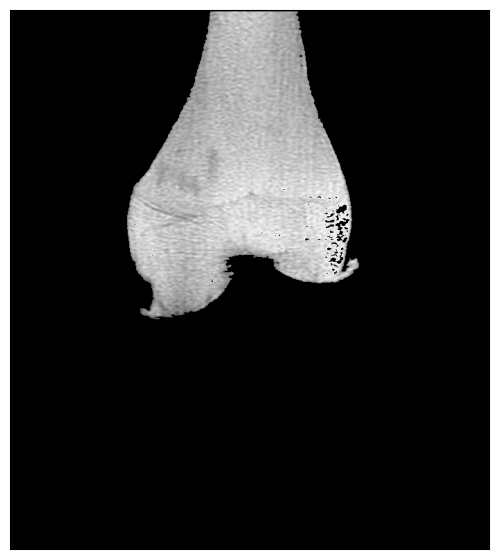

In [8]:
knee_seg = seg_2(knee, 40, 250, 184)
img_show(knee_seg)

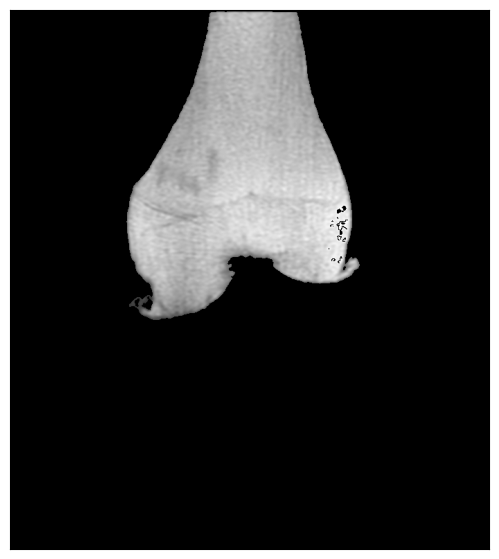

In [9]:
knee_gauss = cv2.GaussianBlur(knee, (7, 7), 0)
knee_seg = seg_2(knee_gauss, 45, 250, 184)
img_show(knee_seg)